# Mitigating Unfairness in the Law School Dataset

In this example, we will examine the well known Law School Admissions dataset, provided by [Project SEAPHE](http://www.seaphe.org/databases.php). The motivation was to gain a better understanding of race in law school admissions, and ensuring that students who would ultimately pass the bar exam were treated fairly.

We shall train a model for an admissions scenario. The model's task will be to provide a means of ranking applicants, and offers would be made to the top students from that list.

## Obtaining the Data

We obtain the data from the `tempeh` package. The main feature data (which we will refer to as $X$) has two features - undergraduate GPA and LSAT score. The label (which we call $y$) is 0 or 1 dependent on whether that student passed the bar exam. Finally, we also have the race of the students as a sensitive attribute, which we will refer to as $A$ (note that this is *not* included in $X$). For simplicity we only consider two races, black and white, and drop the others from the dataset. For reference, in the general US population, there are approximately five times as many whites as blacks.

We start by loading the data, which have already been split into "train" and "test" subsets for us.

In [1]:
import numpy as np
import pandas as pd

from tempeh.configurations import datasets
dataset = datasets['lawschool_passbar']()

X_train = pd.DataFrame(dataset.X_train, columns=dataset.features)
X_test = pd.DataFrame(dataset.X_test, columns=dataset.features)

y_train = pd.Series(dataset.y_train.squeeze(), name="Pass Bar", dtype=int)
y_test = pd.Series(dataset.y_test.squeeze(), name="Pass Bar", dtype=int)

A_train = pd.Series(dataset.race_train, name="Race")
A_test = pd.Series(dataset.race_test, name="Race")

No module named 'torch'. If you want to use pytorch with tempeh please install pytorch separately first.
No modules named 'keras' and 'tensorflow'. If you want to use keras and tensorflow with tempeh please install keras and tensorflow separately first.


Now, let us examine the data. First, we can look at the breakdown of students by race in the dataset. We see that there are over fourteen times as many whites as blacks. This is strongly suggestive of unfairness somewhere - as noted above, in the US population, there are only approximately five times as many whites as blacks.

In [2]:
l, c = np.unique(dataset.race_train, return_counts=True)
for i in range(len(l)):
    print("Number of {0} students is {1}".format(l[i], c[i]))

Number of black students is 880
Number of white students is 12828


We can also start using the group metrics from `fairlearn` to examine things such as the final pass rate for the bar exam. Both rates are high, although higher for whites:

In [3]:
from fairlearn.metrics import group_mean_prediction

def group_metric_printer(name, group_metric_result):
    print("{0} overall {1:.3f}".format(name, group_metric_result.overall))
    for k, v in group_metric_result.by_group.items():
        print("{0} for {1:8} {2:.3f}".format(name, k, v))

unused = np.ones(len(dataset.y_train))
group_metric_printer("Pass Rate", group_mean_prediction(unused, y_train, A_train))

Pass Rate overall 0.956
Pass Rate for black    0.781
Pass Rate for white    0.968


Looking at the raw numbers, we see how dominant whites who pass the bar exam are in the dataset. This will affect how we assess the predictors which we train, since some performance metrics will be overwhelmed by this group:

In [4]:
for r in ['black', 'white']:
    Ys = y_train[A_train==r]
    print(r)
    print(Ys.value_counts())

black
1    687
0    193
Name: Pass Bar, dtype: int64
white
1    12423
0      405
Name: Pass Bar, dtype: int64


We can also examine the [ROC-AUC scores](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) for each feature (that is LSAT score and undergraduate GPA) for the overall dataset and by race. Used in this way, the ROC-AUC score is a measure of how predictive each feature is of the final label. A score of 0.5 would mean that the feature is no better than a coin flip (a coin biased to produce a desired fraction of positives), while a score of 1 means that the feature is perfectly discriminating:

In [5]:
from fairlearn.metrics import group_roc_auc_score

for column_name in X_train:
    column_data = X_train[column_name]
    title = "ROC-AUC {0}".format(column_name)
    group_metric_printer(title, group_roc_auc_score(y_train, column_data, A_train))

ROC-AUC lsat overall 0.745
ROC-AUC lsat for black    0.694
ROC-AUC lsat for white    0.684
ROC-AUC ugpa overall 0.680
ROC-AUC ugpa for black    0.605
ROC-AUC ugpa for white    0.637


We can also examine the CDFs for the LSAT and GPAs for whites and blacks. We see that the blacks appear to have consistently lower feature values for both of these. But remember that the majority still pass the bar exam.

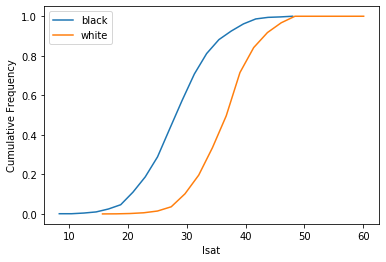

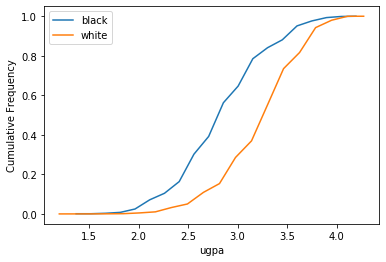

In [6]:
import matplotlib.pyplot as plt
from scipy.stats import cumfreq

def plot_separated_cdf(data, A):
    for a in np.unique(A):
        subset = data[A==a]
        
        cdf = cumfreq(subset, numbins=20)
        x = cdf.lowerlimit + np.linspace(0, cdf.binsize*cdf.cumcount.size, cdf.cumcount.size)
        plt.plot(x, cdf.cumcount / len(subset), label=a)
    plt.xlabel(data.name)
    plt.ylabel("Cumulative Frequency")
    plt.legend()
    plt.show()
        

plot_separated_cdf(X_train['lsat'], A_train)
plot_separated_cdf(X_train['ugpa'], A_train)

## An Unmitigated Predictor

As a point of comparison for later, we can train a predictor without regard to fairness.

In [7]:
from sklearn.linear_model import LogisticRegression

unmitigated_predictor = LogisticRegression(solver='liblinear', fit_intercept=True)

unmitigated_predictor.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

We can examine some statistics for this predictor. Since we have an admissions scenario with a goal of ranking applicants, it is not useful to look at the binary prediction itself (especially since we already know that most students will pass the bar exam). Instead, we use the `predict_proba` method of the `LogisticRegression` estimator, which provides probabilities for each class. We have a binary label column, so we will focus on the "1" class, and we shall refer to the value as a 'score' (to be used in ranking) rather than a probability.

In [8]:
unmitigated_scores = pd.Series(unmitigated_predictor.predict_proba(X_test)[:,1], name="Unmitigated Score")

We can now look at the mean predicted score, and we see that the score predicted for blacks is lower than that for whites. If we were to use this unmitigated predictor, we would perpetuate the imbalance of race:

In [9]:
group_metric_printer("Mean Predicted Score", group_mean_prediction(y_test, unmitigated_scores, A_test))

Mean Predicted Score overall 0.955
Mean Predicted Score for black    0.848
Mean Predicted Score for white    0.963


We can also look at the ROC-AUC scores for the predictions. Due to the huge imbalance in the input population, this is a good metric to use in place of a more conventional accuracy score (since most students pass, one could obtain very good accuracy simply by predicting a value of $1$ for everybody). We see that this predictor is better at discriminating between students who will and will not pass the bar exam than either feature alone:

In [10]:
group_roc_auc_score_unmitigated = group_roc_auc_score(y_test, unmitigated_scores, A_test)
group_metric_printer("Unmitigated ROC-AUC score", group_roc_auc_score_unmitigated)

Unmitigated ROC-AUC score overall 0.784
Unmitigated ROC-AUC score for black    0.717
Unmitigated ROC-AUC score for white    0.736


Finally, we can examine the distribution in predicted score in more detail, by plotting the cumulative frequency curves for each race. Also marked is the maximum distance between the two curves. This is an alternative measure of disparity in the model.

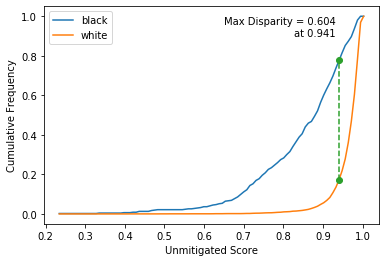

In [11]:
def compare_cdfs(data, A, num_bins=100):
    cdfs = {}
    assert len(np.unique(A)) == 2
    
    limits = ( min(data), max(data) )
    s = 0.5 * (limits[1] - limits[0]) / (num_bins - 1)
    limits = ( limits[0]-s, limits[1] + s)
    
    for a in np.unique(A):
        subset = data[A==a]
        
        cdfs[a] = cumfreq(subset, numbins=num_bins, defaultreallimits=limits)
        
    lower_limits = [v.lowerlimit for _, v in cdfs.items()]
    bin_sizes = [v.binsize for _,v in cdfs.items()]
    actual_num_bins = [v.cumcount.size for _,v in cdfs.items()]
    
    assert len(np.unique(lower_limits)) == 1
    assert len(np.unique(bin_sizes)) == 1
    assert np.all([num_bins==v.cumcount.size for _,v in cdfs.items()])
    
    xs = lower_limits[0] + np.linspace(0, bin_sizes[0]*num_bins, num_bins)
    
    disparities = np.zeros(num_bins)
    for i in range(num_bins):
        cdf_values = np.clip([v.cumcount[i]/len(data[A==k]) for k,v in cdfs.items()],0,1)
        disparities[i] = max(cdf_values)-min(cdf_values)  
    
    return xs, cdfs, disparities
    
    
def plot_and_compare_cdfs(data, A, num_bins=100):
    xs, cdfs, disparities = compare_cdfs(data, A, num_bins)
    
    for k, v in cdfs.items():
        plt.plot(xs, v.cumcount/len(data[A==k]), label=k)
    
    assert disparities.argmax().size == 1
    d_idx = disparities.argmax()
    
    xs_line = [xs[d_idx],xs[d_idx]]
    counts = [v.cumcount[d_idx]/len(data[A==k]) for k, v in cdfs.items()]
    ys_line = [min(counts), max(counts)]
    
    plt.plot(xs_line, ys_line, 'o--')
    disparity_label = "Max Disparity = {0:.3f} \nat {1:0.3f} ".format(disparities[d_idx], xs[d_idx])
    plt.text(xs[d_idx], 1, disparity_label, ha="right", va="top")
    
    plt.xlabel(data.name)
    plt.ylabel("Cumulative Frequency")
    plt.legend()
    plt.show()

    
plot_and_compare_cdfs(unmitigated_scores, A_test)

## Unfairness Mitigation with Grid Search

In this section, we will attempt to mitigate the unfairness in the incoming data using the `GridSearch` algorithm of `fairlearn`. We shall apply constraints of demographic parity - that is, we will attempt to equalise the positive prediction rates between whites and blacks. This is appropriate for affirmative action scenarios, where US law requires that the lowest admission rate (when grouped by race) be at least 80% of the highest admission rate.

We will compute 41 models, on a grid of Lagrange multipliers covering the range $[-10, 10]$, using the same underlying estimator as above. For details on how the search works, refer to section 3.4 of [Agarwal et. al (2018)](https://arxiv.org/abs/1803.02453). The following cell may take a couple of minutes to run:

In [12]:
from fairlearn.reductions import GridSearch, DemographicParity

sweep = GridSearch(LogisticRegression(solver='liblinear', fit_intercept=True),
                   constraints=DemographicParity(),
                   grid_size=41,
                   grid_limit=10)

sweep.fit(X_train, y_train, sensitive_features=A_train)

We can plot the mean score (taken from `predict_proba` as above) as a function of position in the grid. We can see that the mean scores are equalised somewhere between the 30th and 35th models.

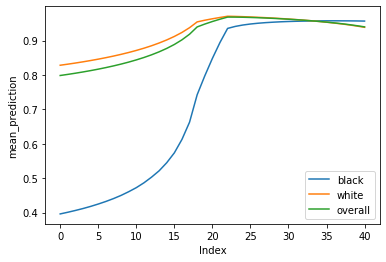

In [13]:
def metric_sweep_plot(all_results, metric_func):
    xs = range(len(all_results))
    metrics = [metric_func(y_test, x.predictor.predict_proba(X_test)[:,1], A_test)
               for x in all_results]
    
    for r in ['black', 'white']:
        plt.plot(xs, [x.by_group[r] for x in metrics], label=r)
    plt.plot(xs, [x.overall for x in metrics], label='overall')
    plt.xlabel("Index")
    plt.ylabel(metric_func.__name__[6:])
    plt.legend()
    plt.show()
    
metric_sweep_plot(sweep.all_results, metric_func=group_mean_prediction)

To assess the performance of each predictor, we make a similar plot of the ROC-AUC scores. We see that the scores are fairly consistent until approximately the 30th model, where the ROC-AUC scores start to fall dramatically:

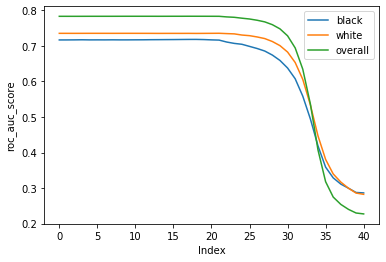

In [14]:
metric_sweep_plot(sweep.all_results, metric_func=group_roc_auc_score)

We can combine the previous two plots into a single one, to give us a better idea of the trade-offs available to us. Each predictor from the grid will be a point on the plot. Its $x$ position will be determined by the smallest ROC-AUC score (that is, the smaller of the ROC-AUC scores for blacks and for whites), providing a measure of predictor performance. The $y$ location of each predictor will be given by the difference in mean score for whites and blacks, providing a measure of disparity.

We see that we can substantially reduce disparity for very little decrease in ROC-AUC score, up to a certain point. After that point, the minimum ROC-AUC score falls dramatically.

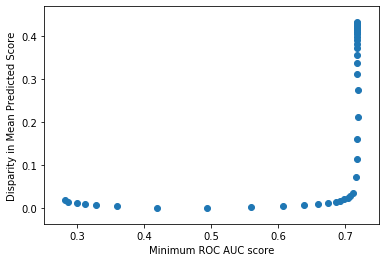

Index of minimum disparity 33


In [15]:
def roc_auc_disparity_sweep_plot(predictors):
    roc_auc = np.zeros(len(predictors))
    disparity = np.zeros(len(predictors))
    
    for i in range(len(predictors)):
        preds = predictors[i].predict_proba(X_test)[:,1]
        roc_auc[i] = group_roc_auc_score(y_test, preds, A_test).minimum
        disparity[i] = group_mean_prediction(y_test, preds, A_test).range
        
    plt.scatter(roc_auc, disparity)
    plt.xlabel("Minimum ROC AUC score")
    plt.ylabel("Disparity in Mean Predicted Score")
    plt.show()
    print("Index of minimum disparity", disparity.argmin())
    
roc_auc_disparity_sweep_plot([x.predictor for x in sweep.all_results])

As an alternative to looking at the disparity in mean predicted score, we can use the maximum distance between the score cumulative distribution functions (for blacks and whites) as the disparity metric for each model. Disparity measured by the maximum difference in cumulative distribution functions is much stricter, since it will only be zero when the two distributions exactly overlap.

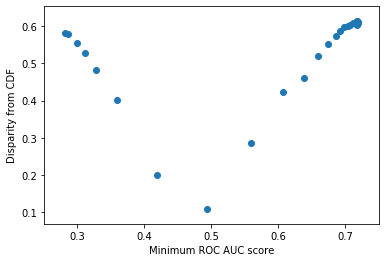

Index of minimum Disparity  33


In [16]:
def roc_auc_cdf_disparity_sweep_plot(predictors):
    roc_auc = np.zeros(len(predictors))
    disparity = np.zeros(len(predictors))
    
    for i in range(len(predictors)):
        preds = predictors[i].predict_proba(X_test)[:,1]
        roc_auc[i] = group_roc_auc_score(y_test, preds, A_test).minimum
        _, _, dis = compare_cdfs(preds, A_test)
        disparity[i] = dis.max()
        
    plt.scatter(roc_auc, disparity)
    plt.xlabel("Minimum ROC AUC score")
    plt.ylabel("Disparity from CDF")
    plt.show()
    print("Index of minimum Disparity ", disparity.argmin())
    
roc_auc_cdf_disparity_sweep_plot([x.predictor for x in sweep.all_results])

We can now look at several different predictors, identified by their index in the results from the grid search. One relevant one is obviously the one with minimum disparity, which occurs at index 33, regardless of the disparity metric chosen. However, the ROC-AUC score is indicating that we're barely better than chosing at random here (slightly better than random for whites, worse than random for blacks - in such a case, one would flip the prediction).

Chosen ROC-AUC score overall 0.536
Chosen ROC-AUC score for black    0.494
Chosen ROC-AUC score for white    0.534
Disparity in Opportunity 0.001


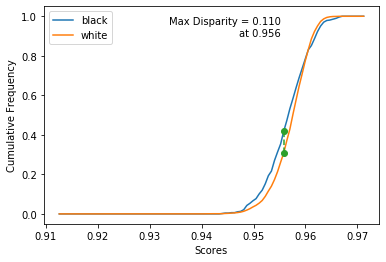

In [17]:
def roc_auc_and_cdf(predictor):
    scores = pd.Series(predictor.predict_proba(X_test)[:,1], name="Scores")
    
    group_metric_printer("Chosen ROC-AUC score", group_roc_auc_score(y_test, scores, A_test))
    print("Disparity in Opportunity {0:.3f}".format(group_mean_prediction(y_test, scores, A_test).range))
    
    plot_and_compare_cdfs(scores, A_test)

roc_auc_and_cdf(sweep.all_results[33].predictor)

We can substantially increase the ROC-AUC score by accepting a slightly higher disparity. The change in disparity in opportunity is minimal, while the change based on the cumulative frequencies is rather larger. However, compared to the unmitigated model above, this is still a substantial improvement.

Chosen ROC-AUC score overall 0.729
Chosen ROC-AUC score for black    0.638
Chosen ROC-AUC score for white    0.683
Disparity in Opportunity 0.007


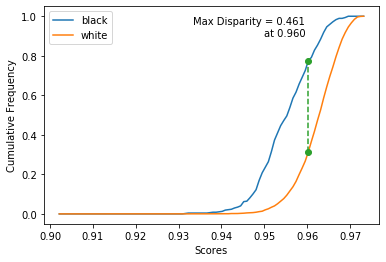

In [18]:
roc_auc_and_cdf(sweep.all_results[30].predictor)

## Mitigation with Threshold Optimisation

We can also use the post-processing approach from `fairlearn`.

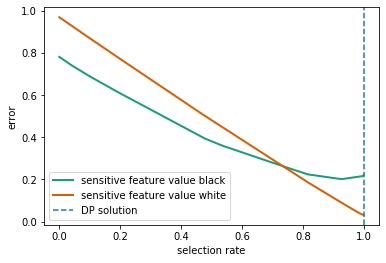

In [19]:
from fairlearn.postprocessing import ThresholdOptimizer

class LogisticRegressionAsRegression:
    def __init__(self, logistic_regression_estimator):
        self.logistic_regression_estimator = logistic_regression_estimator
    
    def fit(self, X, y):
        self.logistic_regression_estimator.fit(X, y)
    
    def predict(self, X):
        # use predict_proba to get real values instead of 0/1, select only prob for 1
        scores = self.logistic_regression_estimator.predict_proba(X)[:,1]
        return scores

est = LogisticRegressionAsRegression(LogisticRegression(solver='liblinear', fit_intercept=True))

postprocess_estimator = ThresholdOptimizer(estimator=est,
                                          constraints="demographic_parity")

postprocess_estimator._plot = True
postprocess_estimator.fit(X_train, y_train, sensitive_features=A_train)

Chosen ROC-AUC score overall 0.500
Chosen ROC-AUC score for black    0.500
Chosen ROC-AUC score for white    0.500
Disparity in Opportunity 0.000


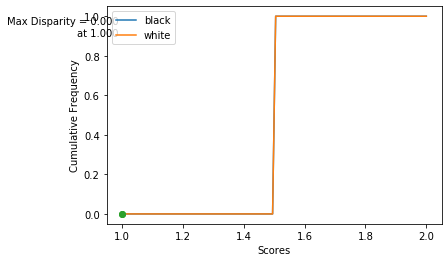

In [20]:
pp_scores = pd.Series(postprocess_estimator.predict(X_test, sensitive_features=A_test), name="Scores")

group_metric_printer("Chosen ROC-AUC score", group_roc_auc_score(y_test, pp_scores, A_test))
print("Disparity in Opportunity {0:.3f}".format(group_mean_prediction(y_test, pp_scores, A_test).range))
    
plot_and_compare_cdfs(pp_scores, A_test)

In [21]:
pp_mean_predictions = group_mean_prediction(y_test, # Actually unused
                                            pp_scores,
                                            A_test)
group_metric_printer("Predicted Pass Rate", pp_mean_predictions)

Predicted Pass Rate overall 1.000
Predicted Pass Rate for black    1.000
Predicted Pass Rate for white    1.000


In [22]:
print(np.unique(pp_scores))

[1]


In [23]:
pp_roc_auc_score = group_roc_auc_score(y_test, pp_scores, A_test)

group_metric_printer("PP ROC-AUC", pp_roc_auc_score)

PP ROC-AUC overall 0.500
PP ROC-AUC for black    0.500
PP ROC-AUC for white    0.500


## Mitigation with Exponentiated Gradient

In [24]:
from fairlearn.reductions import ExponentiatedGradient

expgrad = ExponentiatedGradient(LogisticRegression(solver='liblinear', fit_intercept=True),
                                constraints=DemographicParity(),
                                eps=0.01)

expgrad.fit(X_train, y_train, sensitive_features=A_train)

In [25]:
exp_grad_predictors = expgrad._classifiers

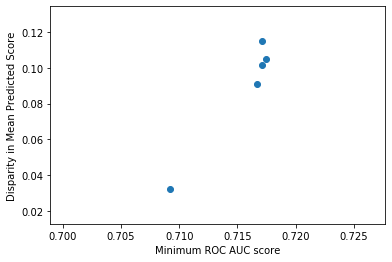

Index of minimum disparity 3


In [26]:
roc_auc_disparity_sweep_plot(exp_grad_predictors)

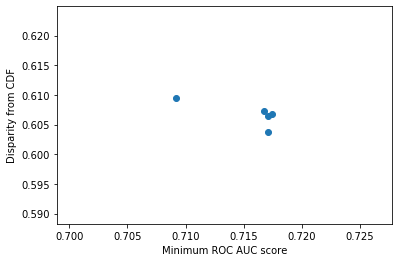

Index of minimum Disparity  0


In [27]:
roc_auc_cdf_disparity_sweep_plot(exp_grad_predictors)

Chosen ROC-AUC score overall 0.784
Chosen ROC-AUC score for black    0.717
Chosen ROC-AUC score for white    0.736
Disparity in Opportunity 0.115


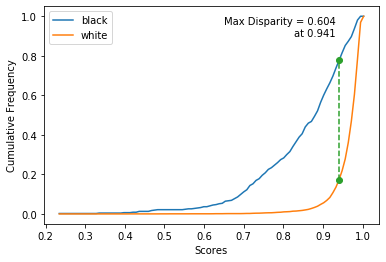

In [28]:
roc_auc_and_cdf(exp_grad_predictors[0])

Chosen ROC-AUC score overall 0.781
Chosen ROC-AUC score for black    0.709
Chosen ROC-AUC score for white    0.734
Disparity in Opportunity 0.032


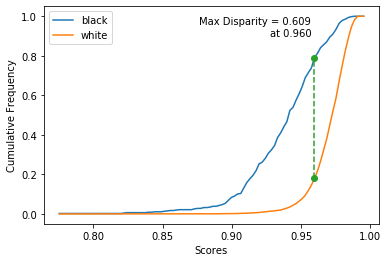

In [29]:
roc_auc_and_cdf(exp_grad_predictors[3])